In [1]:
import torch.nn as nn
import torch
import numpy as np
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import torch
import torch.utils.data
import matplotlib.pyplot as plt
from utils import AvgrageMeter, accuracy, balanced_accuracy

from models.autoencoder import Autoencoder

In [2]:
train_x = np.load('data/k49-train-imgs.npz')['arr_0']
train_y = np.load('data/k49-train-labels.npz')['arr_0']
test_x = np.load('data/k49-test-imgs.npz')['arr_0']
test_y = np.load('data/k49-test-labels.npz')['arr_0']

In [3]:
mean = train_x.mean()
std = train_x.std()

In [4]:
train_x = (train_x - mean) / std
test_x = (test_x - mean) / std

In [5]:
# Map to [-1, 1] so that we can use a tanh function
# train_x = (train_x / 127.5) - 1
# test_x = (test_x / 127.5) - 1

# Map to [0, 1] so that we can use a relu function
# train_x = train_x / 255
# test_x = test_x / 255

In [6]:
ids = np.arange(len(train_x))
np.random.shuffle(ids)

train_x = train_x[ids]
train_y = train_y[ids]

In [7]:
train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
test_x = torch.from_numpy(test_x).type(torch.FloatTensor)

train_y = torch.from_numpy(train_y).type(torch.LongTensor)
test_y = torch.from_numpy(test_y).type(torch.LongTensor)

In [8]:
train = torch.utils.data.TensorDataset(train_x, train_y)
test = torch.utils.data.TensorDataset(test_x, test_y)

In [9]:
batch_size = 1024

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [10]:
class Conv_Classifier(nn.Module):
    def __init__(self):
        super(Conv_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(2, 3, 5, stride=1, padding=2)
        self.fc1 = nn.Linear(3 * 28 * 28, 400)
        self.fc2 = nn.Linear(400, 84)
        self.fc3 = nn.Linear(84, 49)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 1 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
model = Conv_Classifier()

In [16]:
num_epochs = 60
learning_rate = 1e-4

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [17]:
history = []
for epoch in range(num_epochs):
    train_obj = AvgrageMeter()
    test_obj = AvgrageMeter()
    train_acc = AvgrageMeter()
    test_acc = AvgrageMeter()

    for images, labels in train_loader:
        predictions = model(images)
        loss = criterion(predictions, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc.update(accuracy(predictions, labels), len(images))
        train_obj.update(loss.item(), len(images))
        
    for images, labels in test_loader:
        predictions = model(images)
        loss = criterion(predictions, labels)

        test_acc.update(accuracy(predictions, labels), len(images))
        test_obj.update(loss.item(), len(images))
        
    print(f"Epoch {epoch}, LOSS: train {train_obj.avg:.4f} test {test_obj.avg:.4f}. ACCURACY: train {train_acc.avg:.4f} test {test_acc.avg:.4f}")
    history.append((train_obj.avg, test_obj.avg, train_acc.avg, test_acc.avg))
    
history = np.array(history)

Epoch 0, LOSS: train 3.0263 test 2.5446. ACCURACY: train 0.2829 test 0.3949
Epoch 1, LOSS: train 1.7727 test 2.1083. ACCURACY: train 0.5632 test 0.4931
Epoch 2, LOSS: train 1.4410 test 1.8767. ACCURACY: train 0.6390 test 0.5446
Epoch 3, LOSS: train 1.2486 test 1.7173. ACCURACY: train 0.6827 test 0.5796
Epoch 4, LOSS: train 1.1118 test 1.5769. ACCURACY: train 0.7148 test 0.6114
Epoch 5, LOSS: train 1.0099 test 1.4762. ACCURACY: train 0.7393 test 0.6337
Epoch 6, LOSS: train 0.9282 test 1.4013. ACCURACY: train 0.7591 test 0.6525
Epoch 7, LOSS: train 0.8619 test 1.3220. ACCURACY: train 0.7750 test 0.6699
Epoch 8, LOSS: train 0.8064 test 1.2622. ACCURACY: train 0.7892 test 0.6847
Epoch 9, LOSS: train 0.7612 test 1.2118. ACCURACY: train 0.7997 test 0.6961
Epoch 10, LOSS: train 0.7209 test 1.1636. ACCURACY: train 0.8099 test 0.7046
Epoch 11, LOSS: train 0.6848 test 1.1205. ACCURACY: train 0.8191 test 0.7136
Epoch 12, LOSS: train 0.6542 test 1.0847. ACCURACY: train 0.8264 test 0.7243
Epoch 13,

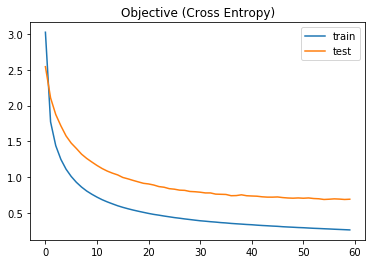

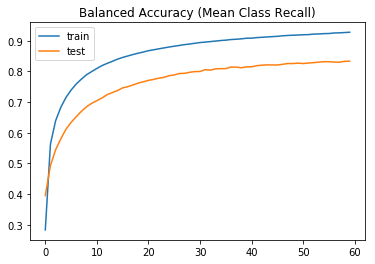

In [18]:
history = np.array(history)

plt.title("Objective (Cross Entropy)")
plt.plot(history[:,0], label="train")
plt.plot(history[:,1], label="test")
plt.legend()
plt.show()

plt.title("Balanced Accuracy (Mean Class Recall)")
plt.plot(history[:,2], label="train")
plt.plot(history[:,3], label="test")
plt.legend()
plt.show()